# CGLE

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cmath

def d_function(D, epsilon, beta):
  return ((3 + 6*D*epsilon*beta) + torch.sqrt((3 + 6*D*epsilon*beta)**2 + 8*(epsilon - 2*D*beta)**2))/( 2*(epsilon - 2*D*beta))

def solution(t, D, delta, epsilon, beta):
  d = d_function(D, epsilon, beta)
  C = torch.sqrt((3*d*(1 + 4*beta**2))/(2*(2*beta - D*epsilon)))
  B = torch.sqrt(delta/(D*d - beta + beta*d**2))

  const = B*C*(1/torch.cosh(B*t))

  return const*torch.cos(d*np.log(const)), const*torch.sin(d*np.log(const))

def omega_function(D, delta, epsilon, beta):
  d = d_function(D, epsilon, beta)
  return -delta*(1 - d**2 + 4*D*beta*d)/(2* (d - D*beta + D*beta*d**2))


# calc lambda 1 and 2 -----> aproximation
def calc_lambda(D, delta, epsilon, beta):
  omega = omega_function(D, delta, epsilon, beta)
  i = complex(0, 1) # imaginary unit
  lambda_square = (i*delta - omega)/(D/2 - i*beta)

  foo_1 = torch.sqrt(lambda_square)
  foo_2 = -torch.sqrt(lambda_square)

  if foo_1.real >= 0:
    return foo_1, foo_2
  else:
    return foo_2, foo_1


class Sech(nn.Module):
    def __init__(self):
        super(Sech, self).__init__()

    def forward(self, x):
        return 2.0 / (torch.exp(x) + torch.exp(-x))


In [ ]:
### modelo real ###
# funcao de ativação pode se definir parametros que se podem otimizar e depois criar a funcao com esses parametros
class Real_Activation(nn.Module):
    def __init__(self, D, delta, epsilon, beta):
      super().__init__()
      self.D = nn.Parameter(torch.tensor(D))
      self.delta = nn.Parameter(torch.tensor(delta))
      self.epsilon = nn.Parameter(torch.tensor(epsilon))
      self.beta = nn.Parameter(torch.tensor(beta))
      self.f0 = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
      lambda_1, lambda_2 = calc_lambda(self.D, self.delta, self.epsilon, self.beta)
      aprox = self.f0 * torch.exp(lambda_1*x) #+ self.offset
      return aprox.real

class ModelReal(nn.Module):
    def __init__(self, D, delta, epsilon, beta):
        super(ModelReal, self).__init__()
        acti = Sech
        self.real_activation = Real_Activation(D, delta, epsilon, beta)

    def forward(self, x):
        real_activation = self.real_activation(x)
        return real_activation


### modelo imaginario ###
class Imag_Activation(nn.Module):
    def __init__(self, D, delta, epsilon, beta):
      super().__init__()
      self.D = nn.Parameter(torch.tensor(D))
      self.delta = nn.Parameter(torch.tensor(delta))
      self.epsilon = nn.Parameter(torch.tensor(epsilon))
      self.beta = nn.Parameter(torch.tensor(beta))
      self.f0 = nn.Parameter(torch.tensor(1.))
      self.offset = nn.Parameter(torch.tensor(4.))

    def forward(self, x):
      lambda_1, lambda_2 = calc_lambda(self.D, self.delta, self.epsilon, self.beta)
      aprox = self.f0 * torch.exp(lambda_1*x) + self.offset
      return aprox.imag


class ModelImag(nn.Module):
    def __init__(self, D, delta, epsilon, beta):
        super(ModelImag, self).__init__()
        self.imag_activation = Imag_Activation(D, delta, epsilon, beta)

    def forward(self, x):
        x = self.imag_activation(x)
        return x


### modelo generalizado
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Visualização de dados

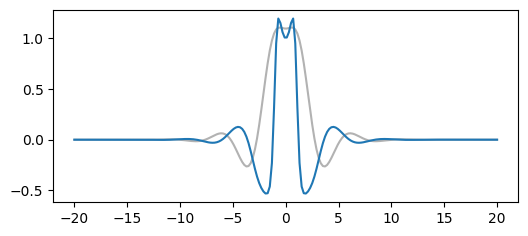

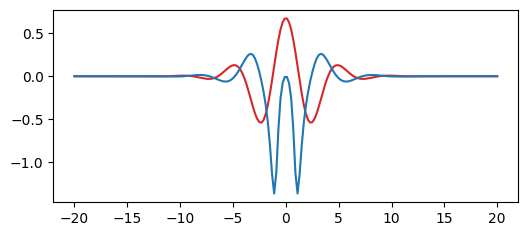

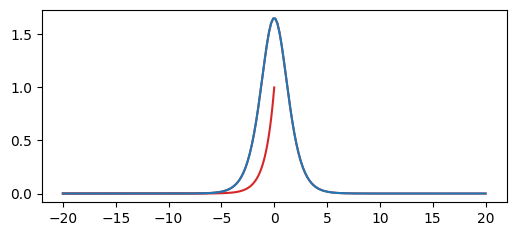

In [ ]:
D, delta, epsilon, beta = -1., -0.1, 0.4, 0.5
D_tensor = torch.Tensor([D])
delta_tensor = torch.Tensor([delta])
epsilon_tensor = torch.Tensor([epsilon])
beta_tensor = torch.Tensor([beta])

boundry = 20
n_points = 200
t = torch.linspace(-boundry,boundry,n_points).view(-1,1)
t_neg = torch.linspace(-boundry,0,n_points).view(-1,1)
t_pos = torch.linspace(0,boundry,n_points).view(-1,1)

start_value = torch.tensor(0.).view(-1,1).requires_grad_(True)


real, imaginario = solution(t, D_tensor, delta_tensor, epsilon_tensor, beta_tensor)
sq = real**2 + imaginario**2


lambda_1, lambda_2 = calc_lambda(D_tensor, delta_tensor, epsilon_tensor, beta_tensor)

f_0 = 1.
f_neg = f_0 * torch.exp(lambda_1*t_neg)
f_pos = f_0 * torch.exp(lambda_2*t_pos)
f=f_0/torch.cosh(lambda_1*t)

sq_aprox = f_neg.real**2 + f_neg.imag**2

plt.figure(figsize=(6,2.5))
plt.plot(t, real, label="real", color="tab:grey", alpha=0.6)
#plt.plot(t_neg, f_neg.real, label="real_aprox", color="tab:green")
plt.plot(t, f.real, label="real_aprox", color="tab:blue")

plt.figure(figsize=(6,2.5))
plt.plot(t, imaginario,label="imag",color="tab:red")
#plt.plot(t_neg, f_neg.imag, label="real_aprox", color="tab:green")
plt.plot(t, f.imag, label="real_aprox", color="tab:blue")


plt.figure(figsize=(6,2.5))
plt.plot(t, sq ,label="sum",color="tab:red")
plt.plot(t_neg, sq_aprox ,label="sum",color="tab:red")

plt.plot(t, sq)


# Real Part and Imaginary Part Separated

In [ ]:
torch.manual_seed(0)
D, delta, epsilon, beta = -1., -0.1, 0.4, 0.5
D_tensor, delta_tensor, epsilon_tensor, beta_tensor = torch.Tensor([D]), torch.Tensor([delta]), torch.Tensor([epsilon]), torch.Tensor([beta])

j = complex(0, 1)

# modelo real
#model_real = ModelReal(D, delta, epsilon, beta)
model_real = FCN(1,1,32,3)

# modelo imaginario
#model_imag = ModelImag(D, delta, epsilon, beta)
model_imag = FCN(1,1,32,3)

# valor do omega
w = omega_function(D_tensor, delta_tensor, epsilon_tensor, beta_tensor).item()

# perda real
loss_array_real = []

#perda imaginária
loss_array_imag = []

#### boundry and number of points
BOUNDRY = 20
N_POINTS = 80

# lamda for negative parte
lambda_neg, lambda_pos = calc_lambda(D_tensor, delta_tensor, epsilon_tensor, beta_tensor)


# função par treinamos só a parte negativa
t_neg = torch.linspace(-BOUNDRY,0,N_POINTS).view(-1,1).requires_grad_(True)

# boundry value
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# otimizador para parte real
optimiser_real = torch.optim.Adam(model_real.parameters(), lr=0.0001)
# otimizador para parte imaginária
optimiser_imag = torch.optim.Adam(model_imag.parameters(), lr=0.0001)


#############################
#### train without phase ####
#############################

for i in range(10000):
    optimiser_real.zero_grad()
    optimiser_imag.zero_grad()


    # boundry
    f_real = torch.mul(model_real(t_boundary),t_boundary+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_boundary)).real
    df_real = torch.autograd.grad(f_real, t_boundary, torch.ones_like(f_real), create_graph=True)[0]

    f_imag = torch.mul(model_imag(t_boundary),t_boundary+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_boundary) ).imag
    df_imag = torch.autograd.grad(f_imag, t_boundary, torch.ones_like(f_imag), create_graph=True)[0]

    boundry_loss = f_real*df_real + f_imag*df_imag

    # physics loss - equação complexa
    #f_real = torch.mul(model_real(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg)).real
    f_real = model_real(t_neg)
    df_real = torch.autograd.grad(f_real, t_neg, torch.ones_like(f_real), create_graph=True)[0]
    ddf_real = torch.autograd.grad(df_real, t_neg, torch.ones_like(df_real), create_graph=True)[0]

    #f_imag = torch.mul(model_imag(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg) ).imag
    f_imag = model_imag(t_neg)
    df_imag = torch.autograd.grad(f_imag, t_neg, torch.ones_like(f_imag), create_graph=True)[0]
    ddf_imag = torch.autograd.grad(df_imag, t_neg, torch.ones_like(df_imag), create_graph=True)[0]


    # perda real
    #loss_real = torch.mean((D*ddf_real/2 + beta*ddf_imag + f_real*w+f_imag*delta + (f_imag**2 + f_real**2)*(epsilon*f_imag + f_real))**2)
    loss_real = torch.mean( ( D*ddf_real/2 + beta*ddf_imag + delta*f_imag + f_imag**2*f_real + f_real**3 + f_real*w + 1 )**2 )

    # perda imaginária
    #loss_imag = torch.mean((D*ddf_imag/2 - beta*ddf_real + f_imag*w-f_real*delta + (f_imag**2 + f_real**2)*(-epsilon*f_real + f_imag))**2)
    loss_imag = torch. mean( D*ddf_imag/2 - beta*ddf_real - delta*f_real - epsilon + f_imag**3 + f_imag*f_real**2 + f_imag*w  )

    loss = loss_real+loss_imag #+boundry_loss

    loss_real = loss
    loss_imag = loss

    loss_array_real.append(loss)
    loss_array_imag.append(loss)

    # retain graph porque estamos a treinar duas redes em simultaneo
    loss_real.backward(retain_graph=True)
    loss_imag.backward()

    optimiser_real.step()
    optimiser_imag.step()

# phase

In [ ]:
#############################
####      add phase      ####
#############################

phase_training = torch.nn.Parameter(torch.tensor([0.]))
optimiser_phase = torch.optim.Adam([phase_training], lr=0.0001)
loss_phase = []

# função par treinamos só a parte negativa
t_neg = torch.linspace(-BOUNDRY,0,N_POINTS).view(-1,1).requires_grad_(True)

for i in range(1000):
    optimiser_phase.zero_grad()

    # physics loss - equação complexa
    f_real = torch.mul(model_real(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg)).real

    f_imag = torch.mul(model_imag(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg) ).imag


    sol = (f_real + j*f_imag) * torch.exp(j*phase_training)

    f_real = sol.real

    df_real = torch.autograd.grad(f_real, t_neg, torch.ones_like(f_real), create_graph=True)[0]
    ddf_real = torch.autograd.grad(df_real, t_neg, torch.ones_like(df_real), create_graph=True)[0]

    f_imag = sol.imag
    df_imag = torch.autograd.grad(f_imag, t_neg, torch.ones_like(f_imag), create_graph=True)[0]
    ddf_imag = torch.autograd.grad(df_imag, t_neg, torch.ones_like(df_imag), create_graph=True)[0]

    # perda real
    loss_real = torch.mean((D*ddf_real/2 + beta*ddf_imag + f_real*w+f_imag*delta + (f_imag**2 + f_real**2)*(epsilon*f_imag + f_real))**2)

    # perda imaginária
    loss_imag = torch.mean((D*ddf_imag/2 - beta*ddf_real + f_imag*w-f_real*delta + (f_imag**2 + f_real**2)*(-epsilon*f_real + f_imag))**2)


    loss_phase.append(phase_training.item())

    # retain graph porque estamos a treinar duas redes em simultaneo
    loss_real.backward(retain_graph=True)
    loss_imag.backward()

    optimiser_phase.step()

tensor(1.1981)


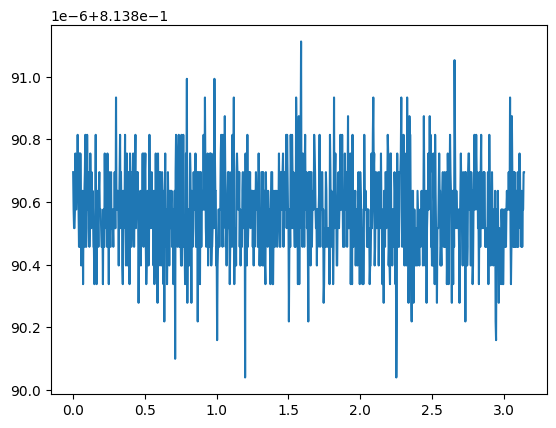

In [ ]:
counts = 1000
loss_arr = []
piarr = torch.linspace(0,np.pi,counts)

best_phase = 0
current_loss = 10000

for phase_ in piarr:
    f_real = torch.mul(model_real(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg)).real
    f_imag = torch.mul(model_imag(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg) ).imag

    sol = (f_real + j*f_imag) * torch.exp(j*phase_)

    f_real = sol.real
    df_real = torch.autograd.grad(f_real, t_neg, torch.ones_like(f_real), create_graph=True)[0]
    ddf_real = torch.autograd.grad(df_real, t_neg, torch.ones_like(df_real), create_graph=True)[0]

    f_imag = sol.imag
    df_imag = torch.autograd.grad(f_imag, t_neg, torch.ones_like(f_imag), create_graph=True)[0]
    ddf_imag = torch.autograd.grad(df_imag, t_neg, torch.ones_like(df_imag), create_graph=True)[0]

    # perda real
    loss_real = torch.mean((D*ddf_real/2 + beta*ddf_imag + f_real*w+f_imag*delta + (f_imag**2 + f_real**2)*(epsilon*f_imag + f_real))**2)

    # perda imaginária
    loss_imag = torch.mean((D*ddf_imag/2 - beta*ddf_real + f_imag*w-f_real*delta + (f_imag**2 + f_real**2)*(-epsilon*f_real + f_imag))**2)

    loss = loss_real + loss_imag

    loss_arr.append(loss.item())
    if loss < current_loss:
      current_loss = loss
      best_phase = phase_

plt.plot(piarr, loss_arr)

print(best_phase)

# draw

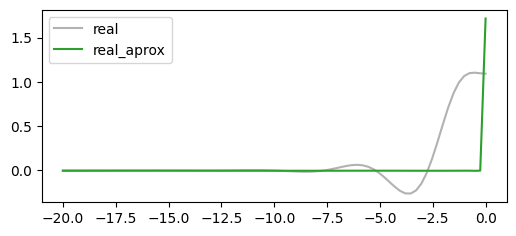

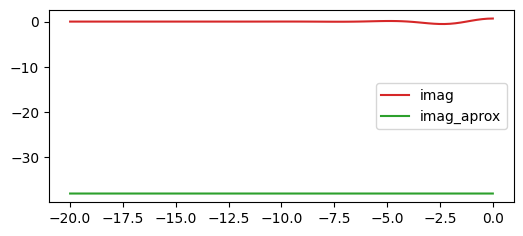

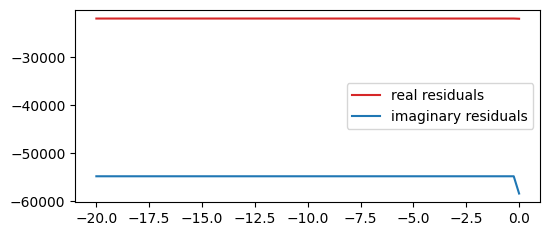

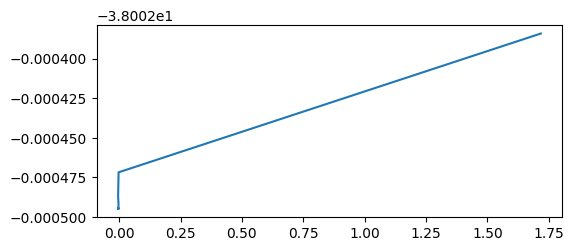

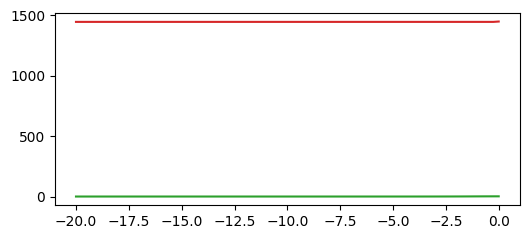

In [ ]:
l_r = [i.detach() for i in loss_array_real]
l_i = [i.detach() for i in loss_array_imag]
w = omega_function(D_tensor, delta_tensor, epsilon_tensor, beta_tensor).item()
d=d_function(D_tensor, epsilon_tensor, beta_tensor)
C = np.sqrt((3*d*(1 + 4*beta_tensor**2))/(2*(2*beta_tensor - D_tensor*epsilon_tensor)))
B = np.sqrt(delta_tensor/(D_tensor*d - beta_tensor + beta_tensor*d**2))

t = torch.linspace(-BOUNDRY,BOUNDRY,N_POINTS).view(-1,1)
t_neg = torch.linspace(-BOUNDRY,0,N_POINTS).view(-1,1).requires_grad_(True)
real, imaginario = solution(t_neg.detach(), D_tensor, delta_tensor, epsilon_tensor, beta_tensor)

#phase_value = best_phase.item() # best phase np.pi/2.
phase_value = 0 #np.pi/2
phase = torch.Tensor([phase_value])

#f_real = torch.mul(model_real(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg)).real
f_real = model_real(t_neg)

#f_imag = torch.mul(model_imag(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg) ).imag
f_imag = model_imag(t_neg)

sol = (f_real + j*f_imag) * torch.exp(j*phase)

f_real = sol.real

f_imag = sol.imag

#f_real=real
#f_imag=imaginario
#f_real=real.view(-1,1).requires_grad_(True)

#f_imag=imaginario.view(-1,1).requires_grad_(True)

dfdt_real = torch.autograd.grad(f_real,t_neg, torch.ones_like(f_real), create_graph=True)[0]
dfdt_imag = torch.autograd.grad(f_imag, t_neg, torch.ones_like(f_imag), create_graph=True)[0]
d2fdt2_real = torch.autograd.grad(dfdt_real, t_neg, torch.ones_like(dfdt_real), create_graph=True)[0]
d2fdt2_imag = torch.autograd.grad(dfdt_imag, t_neg, torch.ones_like(dfdt_imag), create_graph=True)[0]
t_neg=t_neg.detach()
f_real=f_real.detach()
dfdt_real=dfdt_real.detach()
d2fdt2_real=d2fdt2_real.detach()
f_imag=f_imag.detach()
dfdt_imag=dfdt_imag.detach()
d2fdt2_imag=d2fdt2_imag.detach()
residuos_real =(D*d2fdt2_real/2 + beta*d2fdt2_imag + f_real*w+f_imag*delta + (f_imag**2 + f_real**2)*(epsilon*f_imag + f_real))
residuos_imag =(D*d2fdt2_imag/2 - beta*d2fdt2_real + f_imag*w-f_real*delta + (f_imag**2 + f_real**2)*(-epsilon*f_real + f_imag))
residuos_real=residuos_real.detach()
residuos_imag=residuos_imag.detach()

f_real=f_real.detach()
f_imag=f_imag.detach()


plt.figure(figsize=(6,2.5))
plt.plot(t_neg, real, label="real", color="tab:grey", alpha=0.6)
plt.plot(t_neg, f_real[:,0], label="real_aprox", color="tab:green")
plt.legend()

plt.figure(figsize=(6,2.5))
plt.plot(t_neg, imaginario,label="imag",color="tab:red")
plt.plot(t_neg, f_imag[:,0], label="imag_aprox", color="tab:green")
plt.legend()


plt.figure(figsize=(6,2.5))
plt.plot(t_neg,residuos_real,label="real residuals",color="tab:red")
plt.plot(t_neg,residuos_imag, label="imaginary residuals", color="tab:blue")
plt.legend()

#plt.figure(figsize=(6,2.5))
#plt.plot(l_r[:500], label="loss", color="tab:blue")
#plt.legend()

plt.figure(figsize=(6,2.5))
plt.plot(f_real, f_imag)


norm = f_real[:,0]**2 + f_imag[:,0]**2
norm_an = real**2 + imaginario**2

plt.figure(figsize=(6,2.5))
plt.plot(t_neg, norm, label="calc",color="tab:red")
plt.plot(t_neg, norm_an, label="ana",color="tab:green")



# 2 part joining the outputs

In [ ]:
### final model ####

model_final = FCN(2,2,32,3)
t_neg = torch.linspace(-BOUNDRY,0,N_POINTS).view(-1,1).requires_grad_(True)

f_real = torch.mul(model_real(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg)).real
f_imag = torch.mul(model_imag(t_neg),t_neg+BOUNDRY)+ (1/torch.cosh(lambda_neg*t_neg) ).imag
sol = (f_real + j*f_imag) * torch.exp(j*best_phase)

train_real = sol.real
train_imag = sol.imag

optimiser_final = torch.optim.Adam(model_final.parameters(), lr=0.0001)

loss_array_final = []




for i in range(10000):
    optimiser_final.zero_grad()

    # physics loss - equação complexa

    F = model_final(torch.cat((train_real,train_imag),1))

    f_real = F[:, 0]
    df_real = torch.autograd.grad(f_real, t_neg, torch.ones_like(f_real), create_graph=True)[0]
    ddf_real = torch.autograd.grad(df_real, t_neg, torch.ones_like(df_real), create_graph=True)[0]

    f_imag = F[:, 1]
    df_imag = torch.autograd.grad(f_imag, t_neg, torch.ones_like(f_imag), create_graph=True)[0]
    ddf_imag = torch.autograd.grad(df_imag, t_neg, torch.ones_like(df_imag), create_graph=True)[0]

    # physics
    equation = (D/2 - j*beta)*(ddf_real + j*ddf_imag)**2 + (w - delta)*(f_real + j*f_imag) + (1 - j*epsilon)*(f_real**2 + f_imag**2)*(f_real + j*f_imag)

    #loss = torch.sum(loss_real**2 + loss_imag**2)

    loss = torch.mean(equation.real**2 + equation.imag**2)

    loss_array_final.append(loss)

    loss.backward(retain_graph=True)

    optimiser_final.step()



F = model_final(torch.cat((train_real,train_imag),1))
f_real = F[:, 0]
df_real = torch.autograd.grad(f_real, t_neg, torch.ones_like(f_real), create_graph=True)[0]
ddf_real = torch.autograd.grad(df_real, t_neg, torch.ones_like(df_real), create_graph=True)[0]

f_imag = F[:, 1]
df_imag = torch.autograd.grad(f_imag, t_neg, torch.ones_like(f_imag), create_graph=True)[0]
ddf_imag = torch.autograd.grad(df_imag, t_neg, torch.ones_like(df_imag), create_graph=True)[0]

# physics
equation = (D/2 - j*beta)*(ddf_real + j*ddf_imag)**2 + (w - delta)*(f_real + j*f_imag) + (1 - j*epsilon)*(f_real**2 + f_imag**2)*(f_real + j*f_imag)

residuos_real = equation.real
residuos_imag = equation.imag


#### print ####

w = omega_function(D_tensor, delta_tensor, epsilon_tensor, beta_tensor).item()
d=d_function(D_tensor, epsilon_tensor, beta_tensor)
C = np.sqrt((3*d*(1 + 4*beta_tensor**2))/(2*(2*beta_tensor - D_tensor*epsilon_tensor)))
B = np.sqrt(delta_tensor/(D_tensor*d - beta_tensor + beta_tensor*d**2))

t = torch.linspace(-BOUNDRY,BOUNDRY,N_POINTS).view(-1,1)
t_neg = torch.linspace(-BOUNDRY,0,N_POINTS).view(-1,1).requires_grad_(True)
real, imaginario = solution(t_neg.detach(), D_tensor, delta_tensor, epsilon_tensor, beta_tensor)

plt.figure(figsize=(6,2.5))
plt.plot(t_neg.detach(), real, label="real", color="tab:grey", alpha=0.6)
plt.plot(t_neg.detach(), f_real.detach(), label="real_aprox", color="tab:green")
plt.legend()

plt.figure(figsize=(6,2.5))
plt.plot(t_neg.detach(), imaginario,label="imag",color="tab:red")
plt.plot(t_neg.detach(), f_imag.detach(), label="imag_aprox", color="tab:green")
plt.legend()


#plt.figure(figsize=(6,2.5))
#plt.plot(t_neg.detach(),residuos_real.detach(),label="real residuals",color="tab:red")
#plt.plot(t_neg.detach(),residuos_imag.detach(), label="imaginary residuals", color="tab:blue")
#plt.legend()
